In [ ]:
from google.colab import files
uploaded = files.upload()

Saving HackathonDataset.xlsx - ERCOT.csv to HackathonDataset.xlsx - ERCOT (3).csv


In [ ]:
import pandas as pd
import numpy as np

# Load the ERCOT CSV, adjust path if needed
df_raw = pd.read_csv("HackathonDataset.xlsx - ERCOT.csv", skiprows=9)

# Keep the relevant columns
cols_expected = ["Date", "HE", "P_OP", "Gen_MWh", "RT_Busbar", "RT_Hub", "DA_Busbar", "DA_Hub"]
df = df_raw.iloc[:, :8].copy()
df.columns = cols_expected

# Convert Date + Hour Ending into timestamp
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df["HE"] = pd.to_numeric(df["HE"], errors="coerce")
df["Timestamp"] = df["Date"] + pd.to_timedelta(df["HE"] - 1, unit="h")

# Safe numeric cleaning
def clean_numeric(s):
    s = s.astype(str).str.strip()
    s = s.replace(["—", "-", "", " ", "NA", "N/A", "--"], np.nan)
    s = s.str.replace("[$(),]", "", regex=True)
    s = s.where(s.str.match(r"^-?\d+(\.\d+)?$"), np.nan)
    return pd.to_numeric(s, errors="coerce")

for c in ["Gen_MWh", "RT_Busbar", "RT_Hub", "DA_Busbar", "DA_Hub"]:
    df[c] = clean_numeric(df[c])

# Drop invalid rows
df = df.dropna(subset=["Timestamp", "Gen_MWh"])

# Compute basis
df["RT_Basis"] = df["RT_Busbar"] - df["RT_Hub"]
df["DA_Basis"] = df["DA_Busbar"] - df["DA_Hub"]

# Peak/off-peak flag
df["PeakFlag"] = df["P_OP"].apply(lambda x: "Peak" if str(x).strip().upper() == "P" else "OffPeak")

# Monthly summary
monthly_summary = (
    df.groupby([pd.Grouper(key="Timestamp", freq="M"), "PeakFlag"])
    .agg({
        "Gen_MWh": "mean",
        "RT_Hub": "mean",
        "RT_Busbar": "mean",
        "DA_Hub": "mean",
        "DA_Busbar": "mean",
        "RT_Basis": "mean",
        "DA_Basis": "mean"
    })
    .reset_index()
)

print("✅ Cleaning Complete!")
print("Rows:", len(df))
print("Period:", df['Timestamp'].min(), "→", df['Timestamp'].max())
print("Avg Gen (MWh):", round(df['Gen_MWh'].mean(), 2))
print("Avg RT Hub Price ($/MWh):", round(df['RT_Hub'].mean(), 2))
print("Avg DA Hub Price ($/MWh):", round(df['DA_Hub'].mean(), 2))

# View the first few rows
df.head()


/tmp/ipython-input-744985306.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], errors="coerce")


✅ Cleaning Complete!
Rows: 22863
Period: 2022-01-01 00:00:00 → 2024-12-31 23:00:00
Avg Gen (MWh): 23.82
Avg RT Hub Price ($/MWh): 47.17
Avg DA Hub Price ($/MWh): 51.27


/tmp/ipython-input-744985306.py:40: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby([pd.Grouper(key="Timestamp", freq="M"), "PeakFlag"])


,Date,HE,P_OP,Gen_MWh,RT_Busbar,RT_Hub,DA_Busbar,DA_Hub,Timestamp,RT_Basis,DA_Basis,PeakFlag
0,2022-01-01,1,OP,36.8,0.74,56.43,5.20,30.17,2022-01-01 00:00:00,-55.69,-24.97,OffPeak
1,2022-01-01,2,OP,17.0,3.78,29.24,1.54,22.08,2022-01-01 01:00:00,-25.46,-20.54,OffPeak
2,2022-01-01,3,OP,14.6,4.00,22.15,1.83,19.97,2022-01-01 02:00:00,-18.15,-18.14,OffPeak
3,2022-01-01,4,OP,14.6,4.00,19.59,2.50,15.90,2022-01-01 03:00:00,-15.59,-13.40,OffPeak
4,2022-01-01,5,OP,14.4,4.00,13.66,1.34,10.00,2022-01-01 04:00:00,-9.66,-8.66,OffPeak


/tmp/ipython-input-3093695068.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby(pd.Grouper(key="Timestamp", freq="M"))["MerchantRev"]


📊 P75 Fixed Price Estimate: $10.72 per MWh
Data Range: 2022-01-01 to 2024-12-31
Rows: 22,863


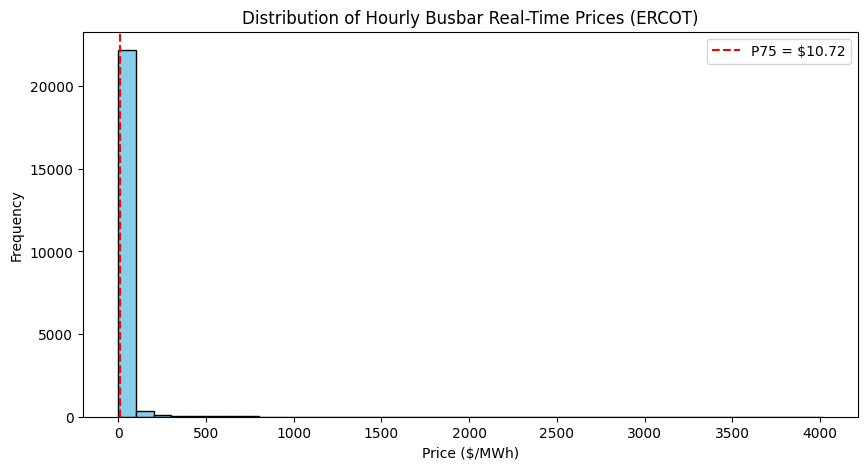

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define helper functions

def simulate_merchant_revenues(df):
    """
    Calculates hourly merchant revenue (generation * busbar RT price)
    and aggregates to monthly total revenue.
    """
    df["MerchantRev"] = df["Gen_MWh"] * df["RT_Busbar"]
    monthly_rev = (
        df.groupby(pd.Grouper(key="Timestamp", freq="M"))["MerchantRev"]
          .sum()
          .reset_index()
          .rename(columns={"MerchantRev": "MonthlyRevenue"})
    )
    return monthly_rev

def calc_p75_price(df, forward_hub_price):
    """
    Computes the fixed P75 price at which 75% of historical merchant outcomes are higher.
    Used to approximate a hedge price.
    """
    merchant_prices = (df["RT_Busbar"]).dropna()
    p75_price = np.percentile(merchant_prices, 25)  # 25th percentile = P75 risk tolerance
    return round(p75_price, 2)

# Step 2: Simulate merchant revenue and calculate P75 price
monthly_rev = simulate_merchant_revenues(df)

p75_price = calc_p75_price(df, None)

print(f"📊 P75 Fixed Price Estimate: ${p75_price} per MWh")
print(f"Data Range: {df['Timestamp'].min().strftime('%Y-%m-%d')} to {df['Timestamp'].max().strftime('%Y-%m-%d')}")
print(f"Rows: {len(df):,}")

# Step 3: Visualize the merchant revenue distribution
plt.figure(figsize=(10,5))
plt.hist(df["RT_Busbar"], bins=40, color="skyblue", edgecolor="black")
plt.axvline(p75_price, color="red", linestyle="--", label=f"P75 = ${p75_price}")
plt.title("Distribution of Hourly Busbar Real-Time Prices (ERCOT)")
plt.xlabel("Price ($/MWh)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


/tmp/ipython-input-1190796796.py:43: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours = pd.date_range(start, end, freq="H", inclusive="both", tz=None)


,Product,P75 Price ($/MWh)
0,RT Hub-settled,31.490000
1,RT Bus-settled,18.900000
2,DA Hub-settled,31.490000
3,DA Bus-settled,21.350000


Expected Generation by Month (MWh) — 2026–2030


,OffPeak,Peak
MonthKey,,
2026-01-01,8454.0896,7492.2942
2026-02-01,6945.4160,7044.4194
2026-03-01,9286.9656,8571.1702
2026-04-01,7582.8120,9540.9796
2026-05-01,10955.1756,8686.7080
2026-06-01,11008.8408,11799.6628
2026-07-01,10844.4370,11908.5526
2026-08-01,8955.4556,8814.2984
2026-09-01,6025.1194,6962.6136


/tmp/ipython-input-1190796796.py:225: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .groupby("MonthKey").apply(lambda g: (g["Price"]*g["Gen"]).sum() / max(g["Gen"].sum(), 1e-9))


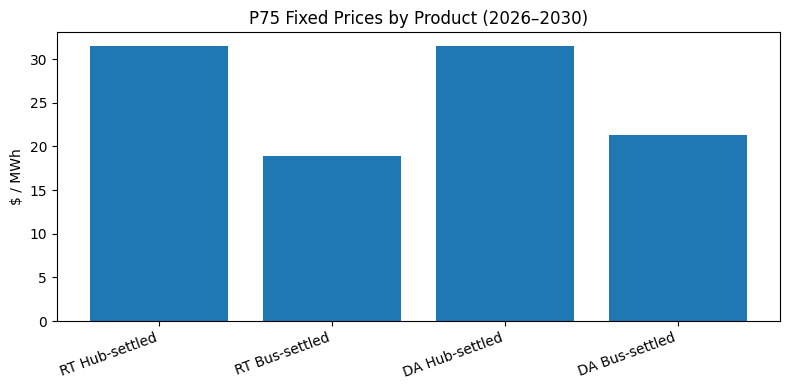

Done. Notes:
- P75 is the 25th percentile of simulated merchant $/MWh (fixed is better in 75% of scenarios).
- Bus-settled uses HUB forward + historical BASIS bootstrap; Hub-settled uses HUB forward.
- Volume risk handled by bootstrapping hourly Gen by (month, Peak/OffPeak).
- You can set USE_FORWARD_FILE=True to use provided hub monthly forwards.
- Set DISCOUNT_RATE>0 to run DCF; current code reports undiscounted P75 prices.


In [ ]:
# 5-Year Valuation (2026–2030) with P75 Prices for RT/DA × Hub/Bus
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from google.colab import files

# 0) Inputs & options
N_SIM = 500                  # Monte Carlo paths
DISCOUNT_RATE = 0.0          # Set to >0 if you want DCF (e.g., 0.06)
USE_FORWARD_FILE = False     # Set True to upload a hub forward file
FLAT_HUB_FWD_PEAK = 35.0     # $/MWh if no forward file
FLAT_HUB_FWD_OFFPEAK = 28.0  # $/MWh if no forward file
PEAK_HE = set(range(7, 23))  # HE 7–22
START = "2026-01-01"
END   = "2030-12-31"

# Forward file format: columns = ["Month","Peak","OffPeak"]
# Month like "2026-01", prices in $/MWh (hub).
if USE_FORWARD_FILE:
    uploaded = files.upload()  # pick your CSV
    fwd_name = list(uploaded.keys())[0]
    fwd_df = pd.read_csv(fwd_name)
    # make a full month index
    fwd_df["Month"] = pd.to_datetime(fwd_df["Month"] + "-01")
    fwd_df = fwd_df.sort_values("Month").set_index("Month")
else:
    fwd_df = None  # Will fallback to flat forwards

# 1) Helpers
def is_peak(ts):
    # Mon–Fri and HE in [7..22]
    dow = ts.weekday()  # 0=Mon
    he = ts.hour + 1    # Hour-ending
    return (dow < 5) and (he in PEAK_HE)

def make_calendar(start, end):
    # Hourly calendar
    hours = pd.date_range(start, end, freq="H", inclusive="both", tz=None)
    cal = pd.DataFrame({"Timestamp": hours})
    cal["Month"] = cal["Timestamp"].values.astype("datetime64[M]")
    cal["PeakFlag"] = np.where(cal["Timestamp"].apply(is_peak), "Peak", "OffPeak")
    return cal

def month_blocks(start, end):
    months = pd.date_range(start, end, freq="MS")
    return pd.DataFrame({"Month": months})

def bootstrap_series(values, size):
    # Sample with replacement, ignoring NaNs
    v = pd.Series(values).dropna().values
    if len(v) == 0:
        return np.zeros(size)
    return np.random.choice(v, size=size, replace=True)

def p75_price_from_path_hourly(price_hourly, gen_hourly):
    # Price_hourly in $/MWh, gen in MWh
    # Merchant $/MWh per path = (sum(gen*price)/sum(gen)) ; P75 = 25th percentile
    with np.errstate(divide="ignore", invalid="ignore"):
        denom = gen_hourly.sum(axis=1)
        denom[denom == 0] = np.nan
        mwh_price = (gen_hourly * price_hourly).sum(axis=1) / denom
    return np.nanpercentile(mwh_price, 25)

def discount_factors(month_index, annual_rate):
    if annual_rate == 0 or annual_rate is None:
        return np.ones(len(month_index))
    # Assume mid-month discounting
    ref = month_index.min()
    years = ((month_index - ref) / pd.Timedelta(days=365)).astype(float)
    return (1.0 / (1.0 + annual_rate) ** years).values

# 2) Historical distributions (from df cleaned earlier)
# Gen by (month, peakflag)
# Hub price & basis by (month, peakflag) for RT & DA
df_hist = df.copy()
df_hist["Month"] = df_hist["Timestamp"].values.astype("datetime64[M]")

# Map PeakFlag robustly
df_hist["PeakFlag"] = np.where(df_hist["PeakFlag"].str.lower().str.contains("peak"), df_hist["PeakFlag"],
                               np.where(df_hist["P_OP"].astype(str).str.upper()=="P", "Peak", "OffPeak"))

# Build dictionaries of arrays for bootstrap by (month_num, peakflag)
df_hist["mnum"] = df_hist["Timestamp"].dt.month
def keyer(ts_month, peak):
    # Use month-of-year seasonality if future months exceed history span
    return (ts_month.month, peak)

# Group raw arrays
hist_gen = {}
hist_rt_hub = {}
hist_rt_basis = {}
hist_da_hub = {}
hist_da_basis = {}

for (mnum, peak), grp in df_hist.groupby([df_hist["Timestamp"].dt.month, "PeakFlag"]):
    hist_gen[(mnum, peak)] = grp["Gen_MWh"].dropna().values
    hist_rt_hub[(mnum, peak)] = grp["RT_Hub"].dropna().values
    hist_rt_basis[(mnum, peak)] = (grp["RT_Busbar"] - grp["RT_Hub"]).dropna().values
    hist_da_hub[(mnum, peak)] = grp["DA_Hub"].dropna().values
    hist_da_basis[(mnum, peak)] = (grp["DA_Busbar"] - grp["DA_Hub"]).dropna().values

# 3) Create future calendar (hourly) and attach hub forwards
cal = make_calendar(START, END)
cal["mnum"] = cal["Timestamp"].dt.month

# Build monthly forward hub price table with Peak/OffPeak
months = month_blocks(START, END)
months["Peak"] = FLAT_HUB_FWD_PEAK
months["OffPeak"] = FLAT_HUB_FWD_OFFPEAK
months = months.set_index("Month")

if fwd_df is not None:
    # Override flat with uploaded forward curve where present
    # Assume fwd_df has Peak/OffPeak columns
    months.loc[months.index.intersection(fwd_df.index), "Peak"] = fwd_df.loc[months.index.intersection(fwd_df.index), "Peak"].values
    months.loc[months.index.intersection(fwd_df.index), "OffPeak"] = fwd_df.loc[months.index.intersection(fwd_df.index), "OffPeak"].values

# Map forward hub price to each hour by month & PeakFlag
cal = cal.merge(months.reset_index().rename(columns={"Month":"MonthKey"}), left_on=cal["Month"], right_on="MonthKey", how="left")
cal["HubFwd"] = np.where(cal["PeakFlag"]=="Peak", cal["Peak"], cal["OffPeak"])
cal = cal.drop(columns=[col for col in ["key_0","MonthKey","Peak","OffPeak"] if col in cal.columns])


# 4) Monte Carlo simulation: generate hourly generation and basis values
# Apply hub forward prices to get four products (RT/DA × Hub/Bus)
# Group by month later for aggregation
cal["MonthKey"] = cal["Month"]

# Pre-allocate arrays [paths, hours]
H = len(cal)
idx_hours = cal.index.values

def simulate_hourly_prices_and_gen():
    # Bootstrap gen & basis by (month-of-year, peakflag)
    mnums = cal["mnum"].values
    pflags = cal["PeakFlag"].values

    # sample gen
    gen = np.zeros((N_SIM, H))
    for i in range(H):
        arr = hist_gen.get((mnums[i], pflags[i]), np.array([0.0]))
        gen[:, i] = bootstrap_series(arr, N_SIM)

    # BASIS (RT/DA)
    basis_rt = np.zeros((N_SIM, H))
    basis_da = np.zeros((N_SIM, H))
    for i in range(H):
        arr_rt = hist_rt_basis.get((mnums[i], pflags[i]), np.array([0.0]))
        arr_da = hist_da_basis.get((mnums[i], pflags[i]), np.array([0.0]))
        basis_rt[:, i] = bootstrap_series(arr_rt, N_SIM)
        basis_da[:, i] = bootstrap_series(arr_da, N_SIM)

    # Use forward prices as the base hub level
    hub_forward = cal["HubFwd"].values.astype(float)
    hub_rt = np.tile(hub_forward, (N_SIM, 1))   # mean-level hub (RT)
    hub_da = np.tile(hub_forward, (N_SIM, 1))   # mean-level hub (DA)

    # BUSBAR = HUB + BASIS
    bus_rt = hub_rt + basis_rt
    bus_da = hub_da + basis_da

    return gen, hub_rt, bus_rt, hub_da, bus_da

gen, hub_rt, bus_rt, hub_da, bus_da = simulate_hourly_prices_and_gen()

# 5) Compute P75 fixed prices ($/MWh) for each product
p75_rt_hub = round(p75_price_from_path_hourly(hub_rt, gen), 2)
p75_rt_bus = round(p75_price_from_path_hourly(bus_rt, gen), 2)
p75_da_hub = round(p75_price_from_path_hourly(hub_da, gen), 2)
p75_da_bus = round(p75_price_from_path_hourly(bus_da, gen), 2)

p75_table = pd.DataFrame({
    "Product": ["RT Hub-settled", "RT Bus-settled", "DA Hub-settled", "DA Bus-settled"],
    "P75 Price ($/MWh)": [p75_rt_hub, p75_rt_bus, p75_da_hub, p75_da_bus]
})
display(p75_table.style.set_table_styles([{'selector': 'th', 'props': [('display', 'none')]}]))


# 6) Expected monthly generation (Peak and Off-Peak), 2026–2030
# Calculates the average generation across all simulation runs
# Then sums it by month for Peak and Off-Peak periods
gen_exp_hour = np.nanmean(gen, axis=0)
cal["GenExp"] = gen_exp_hour
gen_month = cal.groupby(["MonthKey","PeakFlag"])["GenExp"].sum().reset_index()
gen_month_pivot = gen_month.pivot(index="MonthKey", columns="PeakFlag", values="GenExp").fillna(0.0)
gen_month_pivot = gen_month_pivot.rename_axis(None, axis=1)

print("Expected Generation by Month (MWh) — 2026–2030")
display(gen_month_pivot.head(12))

# 7) (Optional) Discounted valuation comparison: merchant vs fixed
# Build DF factors per month
df_months = gen_month.groupby("MonthKey")["GenExp"].sum().reset_index().rename(columns={"GenExp":"Gen_MWh"})
df_months = df_months.sort_values("MonthKey")
dfs = discount_factors(df_months["MonthKey"], DISCOUNT_RATE)

# Example merchant EV under RT Bus (expected hub forward + sampled basis mean ~0)
# Here we use expected value approach (not full distribution)
# For full distribution, aggregate each path monthly and compare—kept light here for speed.
# Mean across all paths & hours
bus_rt_mean_hour = np.nanmean(bus_rt, axis=0)
ev_month_rt_bus = (
    pd.DataFrame({"MonthKey": cal["MonthKey"].values,
                  "Price": bus_rt_mean_hour,
                  "Gen": gen_exp_hour})
    .groupby("MonthKey").apply(lambda g: (g["Price"]*g["Gen"]).sum() / max(g["Gen"].sum(), 1e-9))
    .rename("EV_Price_$perMWh")
    .reset_index()
)


# 8) Visuals
plt.figure(figsize=(8,4))
plt.bar(p75_table["Product"], p75_table["P75 Price ($/MWh)"])
plt.title("P75 Fixed Prices by Product (2026–2030)")
plt.xticks(rotation=20, ha="right")
plt.ylabel("$ / MWh")
plt.tight_layout()
plt.show()

print("Done. Notes:")
print("- P75 is the 25th percentile of simulated merchant $/MWh (fixed is better in 75% of scenarios).")
print("- Bus-settled uses HUB forward + historical BASIS bootstrap; Hub-settled uses HUB forward.")
print("- Volume risk handled by bootstrapping hourly Gen by (month, Peak/OffPeak).")
print("- You can set USE_FORWARD_FILE=True to use provided hub monthly forwards.")
print("- Set DISCOUNT_RATE>0 to run DCF; current code reports undiscounted P75 prices.")
